In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import holidays
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
sns.set_theme()

Carguemos los datos para prueba:

In [3]:
df = pd.read_parquet('../data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
df.drop(columns='fecha', inplace=True)
df.set_index('datetime', inplace=True)
df.head()

,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
datetime,,,,,,,,,,,,,,,
2023-11-01 00:00:00,0.0,8.6725,0.0,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
2023-11-01 01:00:00,1.0,8.5725,0.1,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2023-11-01 02:00:00,2.0,8.3225,0.0,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
2023-11-01 03:00:00,3.0,8.0725,0.1,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
2023-11-01 04:00:00,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


Definamos una función que recibe un dataframe con las variables exógenas y la demanda de todos los ditritos de nueva york, y devuelve modelos SARIMAX entrenados para cada distrito. En este caso, vamos a necesitar 5 modelos diferentes, ya que probablemente los ordenes de cada distrito (p, d y q) sean diferentes, y SARIMAX de statsmodels no permite órdenes diferentes para las columnas de series temporales.

In [7]:
def generar_modelos(df, exog=['hora', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall', 'año', 'mes', 'dia', 'dia_semana', 'holiday'],
                    endog=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], train_size = 0.8
                    ):
    n = len(df)
    train_n = int(n * train_size)

    endog_train_data = df[endog][:train_n]
    endog_test_data = df[endog][train_n:]

    exog_train_data = df[exog][:train_n]
    exog_test_data = df[exog][train_n:]

    models = {}
    predictions = {}
    errors = {}

    for district in endog:
        print('Inicio de evaluación de', district)
        model = pm.auto_arima(endog_train_data[district], exogenous=exog_train_data, seasonal=True, m=24)
        order = model.order
        seasonal_order = model.seasonal_order
        print("Order:", order)
        print("Seasonal order:", seasonal_order)

        models[district] = model

        # Obtener las predicciones y los intervalos de confianza
        forecast = model.predict(n_periods=len(endog_test_data), exogenous=exog_test_data, return_conf_int=True)
        predicted_values = forecast[0]
        confidence_intervals = forecast[1]

        # Crear un DataFrame con las predicciones y los intervalos de confianza
        predictions_df = pd.DataFrame({
        'Predicted': predicted_values.values,
        'Lower Confidence Interval': confidence_intervals[:, 0],
        'Upper Confidence Interval': confidence_intervals[:, 1],
        'Real values': endog_test_data[district].values
        })
        predictions_df.set_index(endog_test_data.index, inplace=True)
        predictions[district] = predictions_df

        y_true = endog_test_data[district].values  # valores reales
        y_pred = predictions_df['Predicted'].values  # predicciones del modelo

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}
        print('RMSE:', rmse)
        print('-----------------------------------------------------------------------------------------')
    return models, predictions, errors

In [5]:
def graficar_predicciones(predictions):
    for district, data in predictions.items():
        plt.figure(figsize=(20, 10))
        plt.plot(data['Real values'], label='Test Data', color='green')
        plt.plot(data['Predicted'], label='Predictions', color='red')
        plt.fill_between(data.index, data['Lower Confidence Interval'], data['Upper Confidence Interval'], color='pink', alpha=0.3)
        plt.legend()
        plt.title(f'SARIMAX Predictions for {district}')
        plt.xlabel('Date')
        plt.ylabel('Demand')
        plt.show()

In [9]:
models, predictions, errors = generar_modelos(df)

Inicio de evaluación de Bronx
Order: (5, 0, 1)
Seasonal order: (2, 0, 0, 24)
RMSE: 7.2155232943380785
-----------------------------------------------------------------------------------------
Inicio de evaluación de Brooklyn
Order: (0, 1, 0)
Seasonal order: (0, 0, 0, 24)
RMSE: 36.42969759542615
-----------------------------------------------------------------------------------------
Inicio de evaluación de Manhattan
Order: (1, 0, 2)
Seasonal order: (1, 0, 2, 24)
RMSE: 2362.487291257889
-----------------------------------------------------------------------------------------
Inicio de evaluación de Queens
Order: (2, 0, 0)
Seasonal order: (2, 0, 1, 24)
RMSE: 109.86868004297624
-----------------------------------------------------------------------------------------
Inicio de evaluación de Staten Island
Order: (5, 1, 1)
Seasonal order: (0, 0, 0, 24)
RMSE: 0.32439457070966987
-----------------------------------------------------------------------------------------


El entrenamiento de los predictores de cada distrito duró 19 minutos en total.

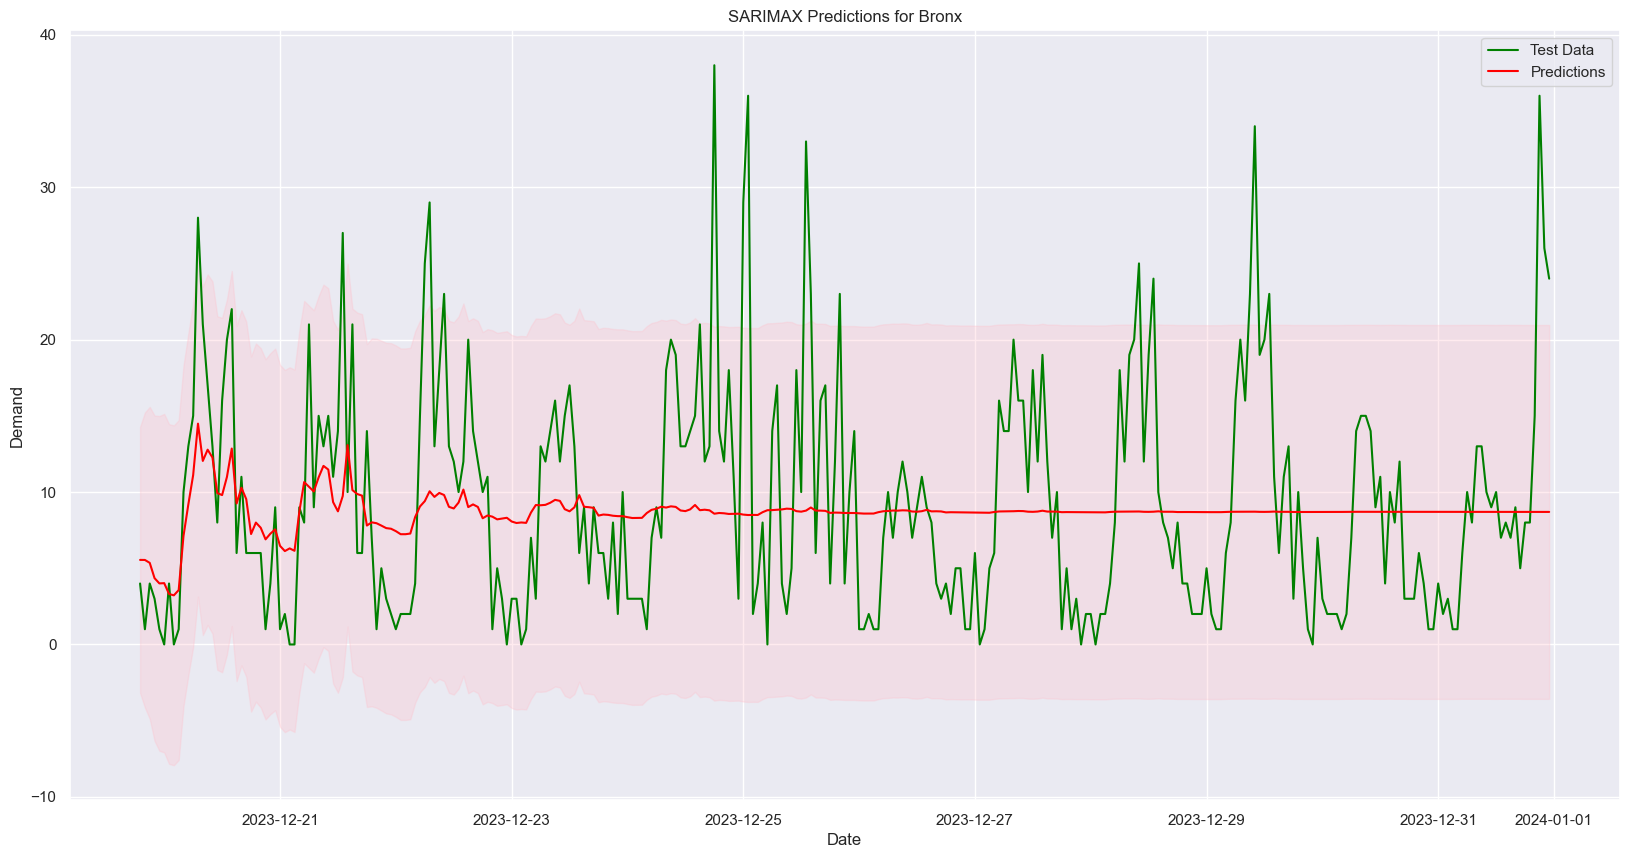

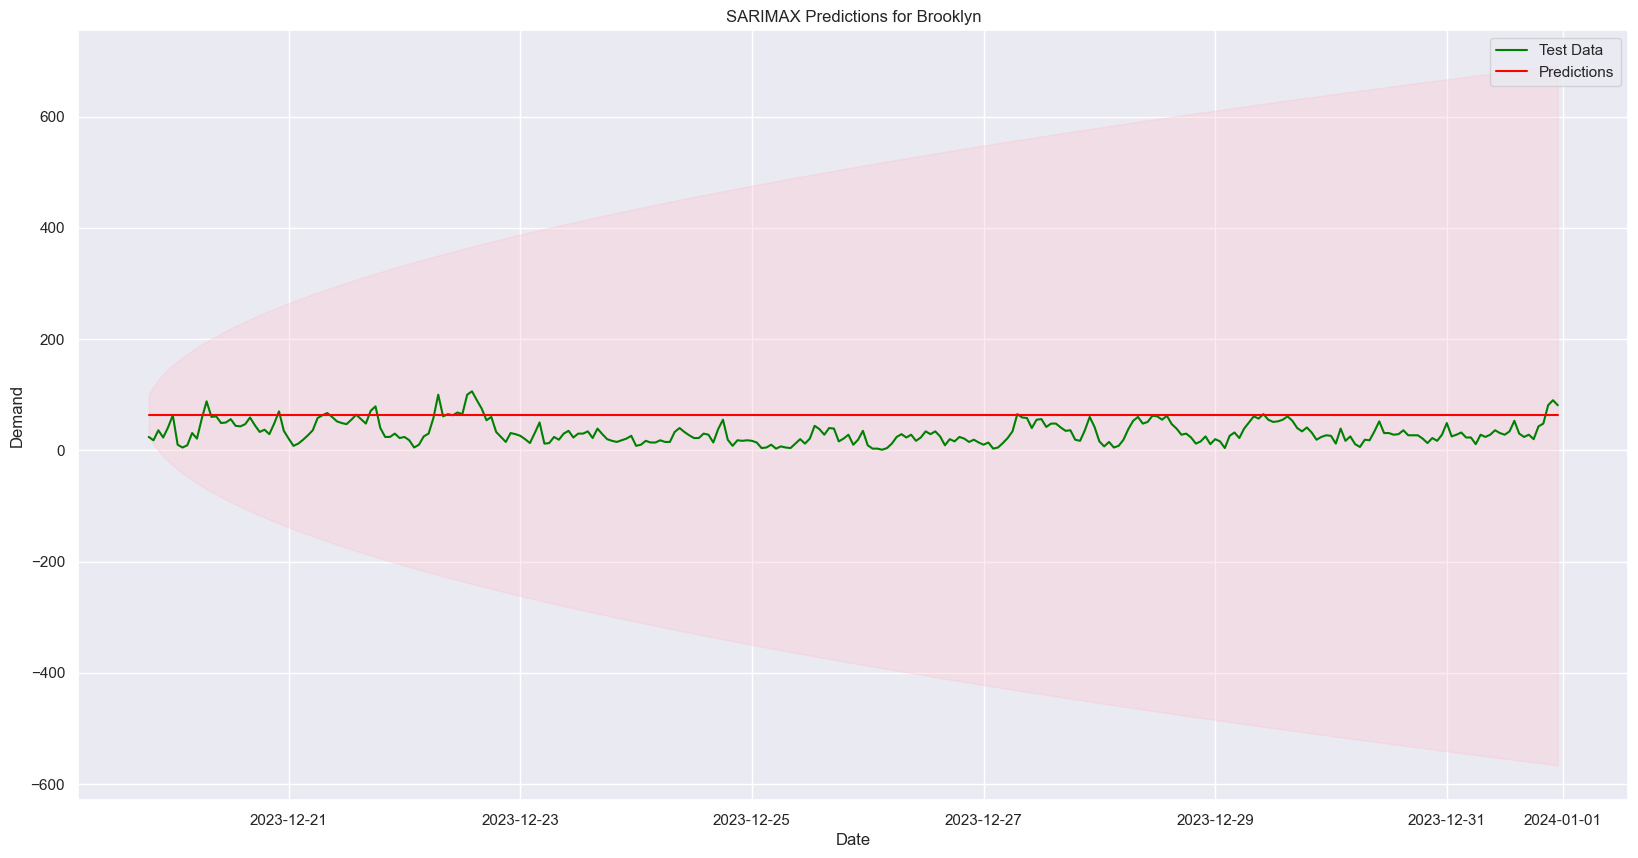

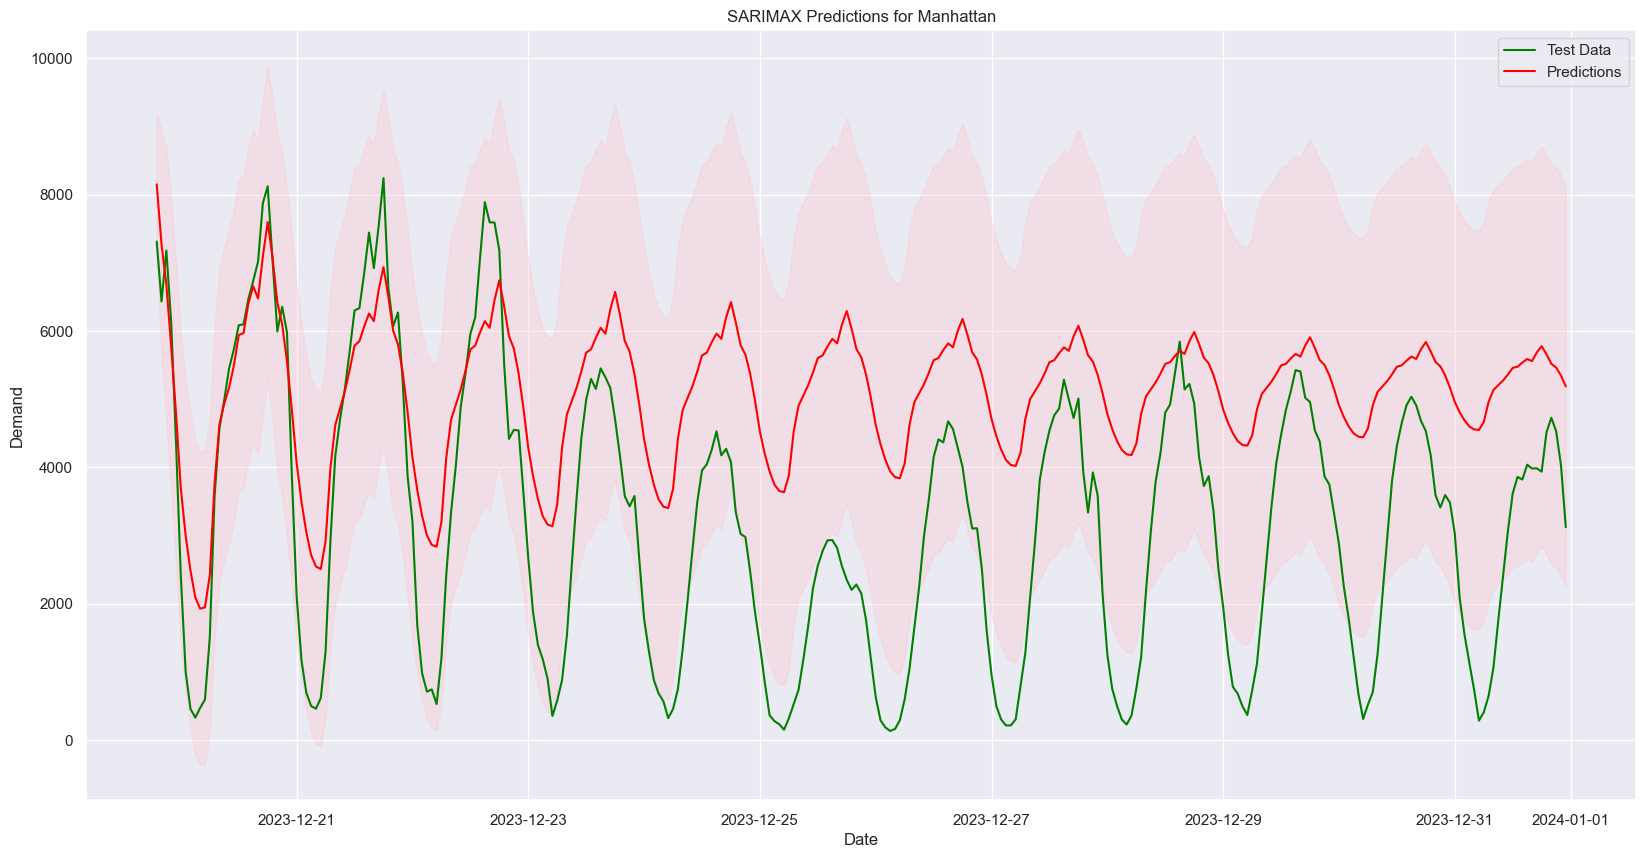

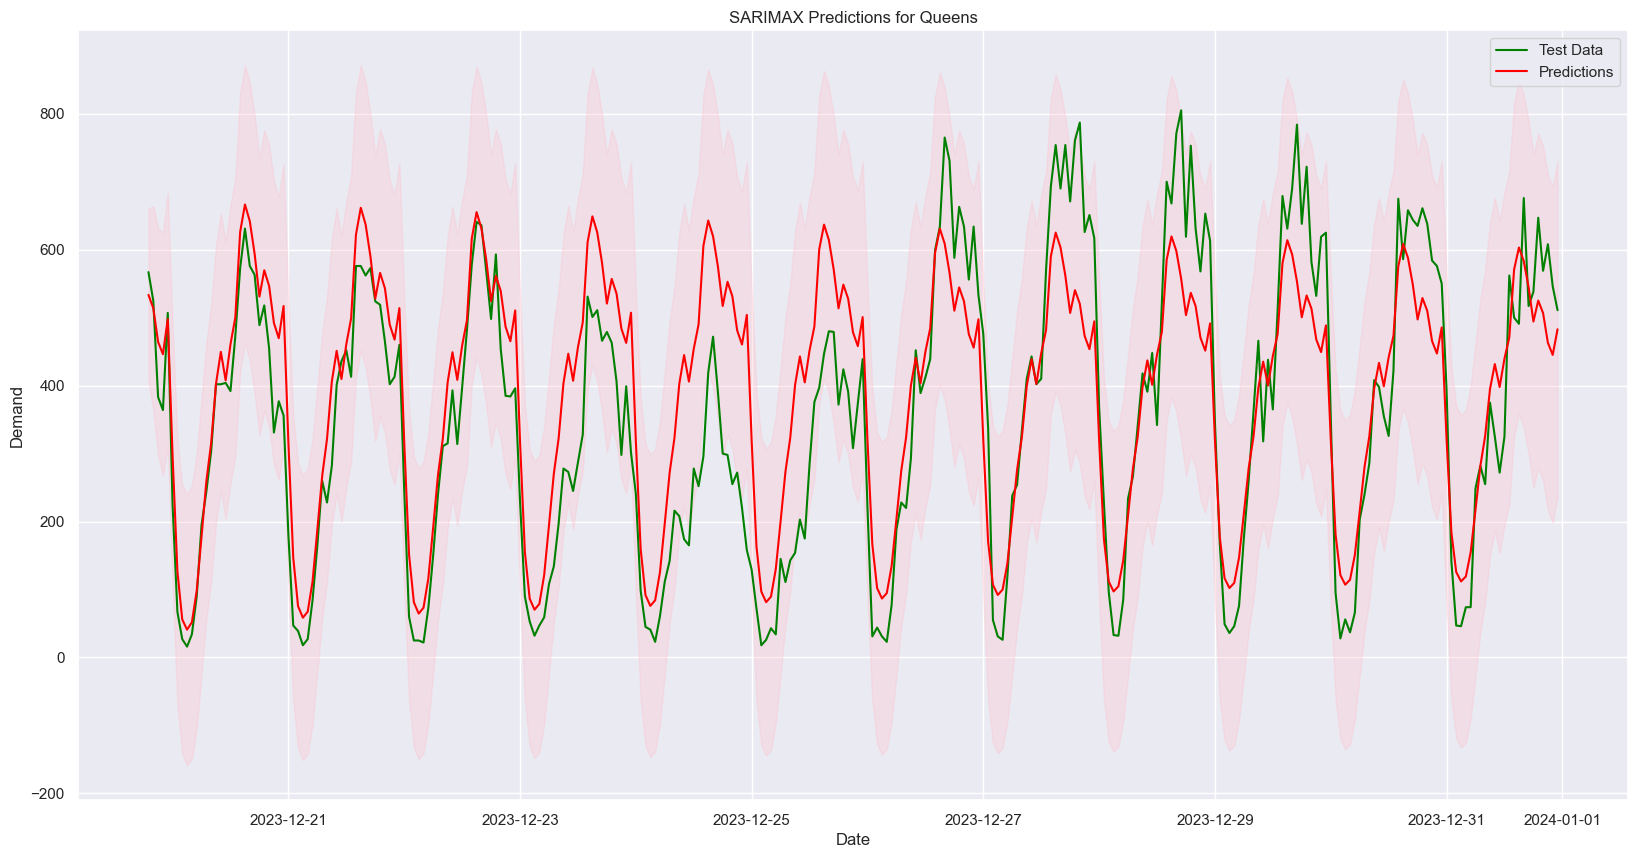

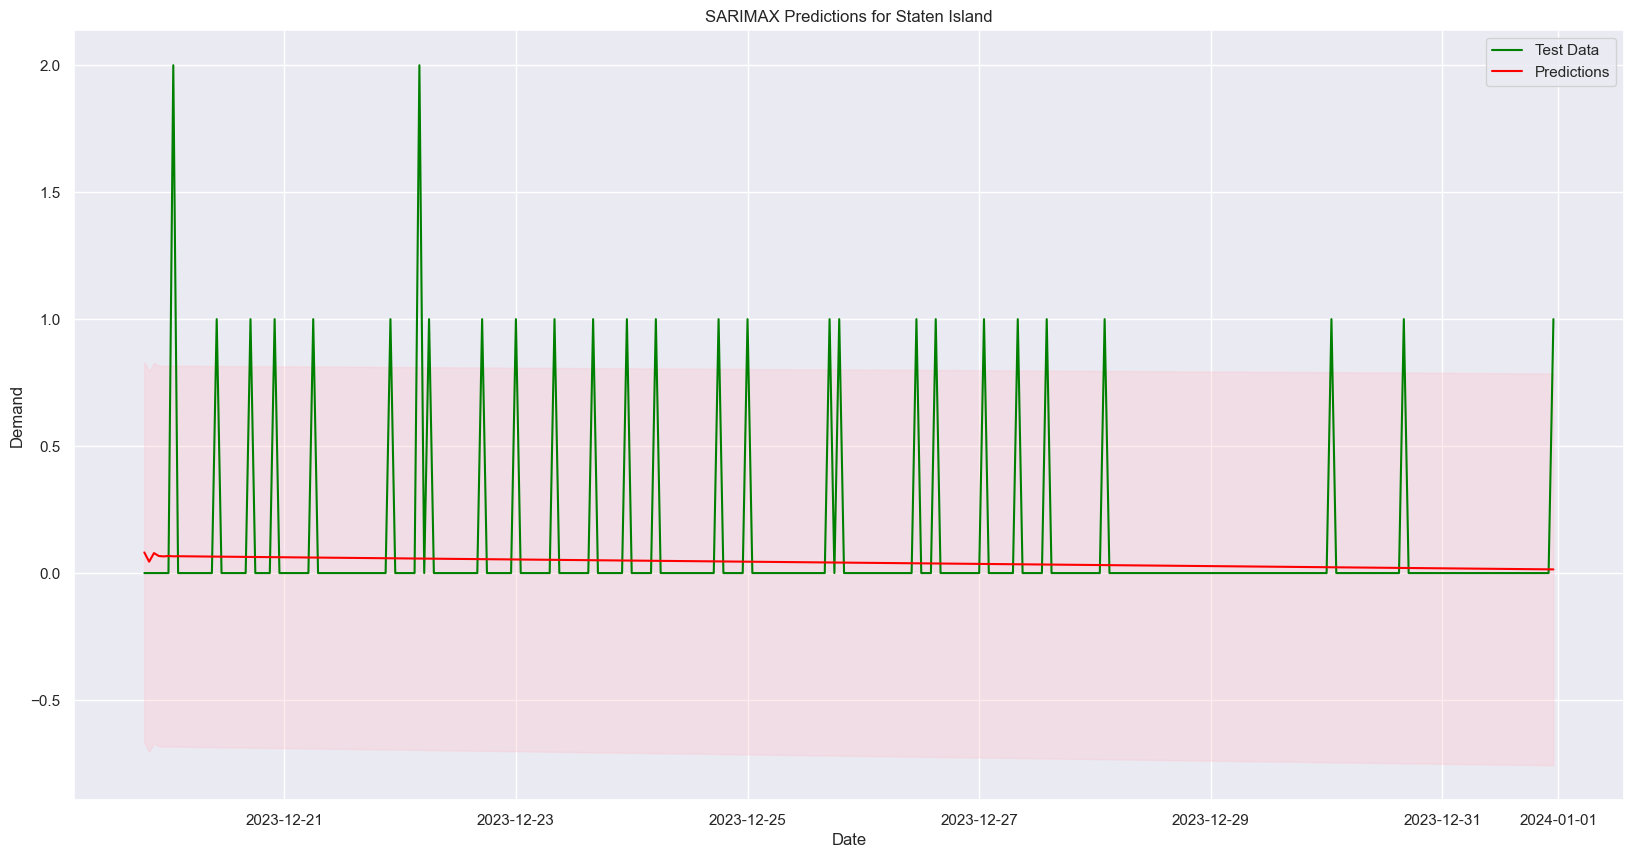

In [10]:
graficar_predicciones(predictions)